In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from deployment.dataloader import *
from deployment.misc import *

%load_ext autoreload
%autoreload 1
%aimport deployment.dataloader
%aimport deployment.misc
%aimport methods.grad_cam
%aimport methods.grad_based
%aimport methods.occlusion
%aimport methods.bottleneck
%aimport methods.base

In [2]:
# setup dev
device = torch.device("cuda")
print("device is", device)

# setup net
def make_model():
    return torchvision.models.vgg19_bn(pretrained=True).to(device)
    
# setup data
loader = DataLoader()
from scipy.constants import ounce
    

device is cuda


In [3]:
original = make_model()
print(original)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /home/karlschulz/.torch/models/vgg19_bn-c79401a0.pth
100%|██████████| 574769405/574769405 [00:10<00:00, 53228985.23it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [4]:
# reset
noised = make_model()

hooking Conv2d
hooking BatchNorm2d
hooking ReLU
hooking Conv2d
hooking Conv2d
-0.11298493
0.30240855
0.010309216
0.17994277
0.065189905
0.11414391
-0.13311
0.26056433
-0.17503573
0.1525581
394
394


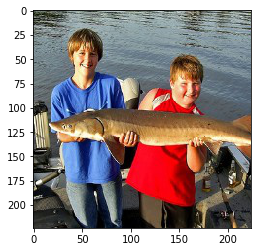

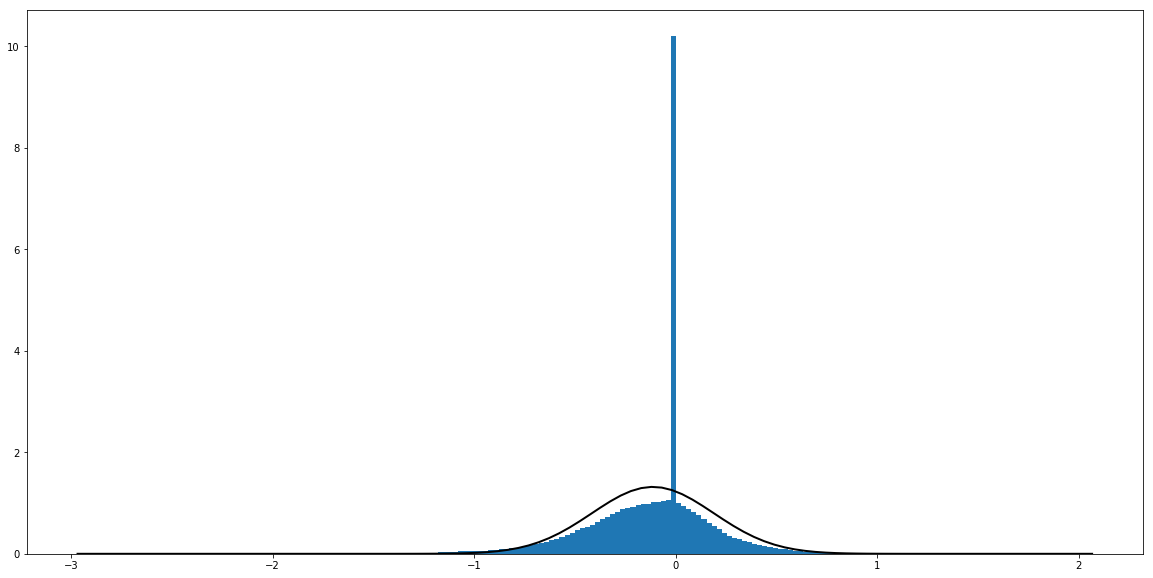

<Figure size 432x288 with 0 Axes>

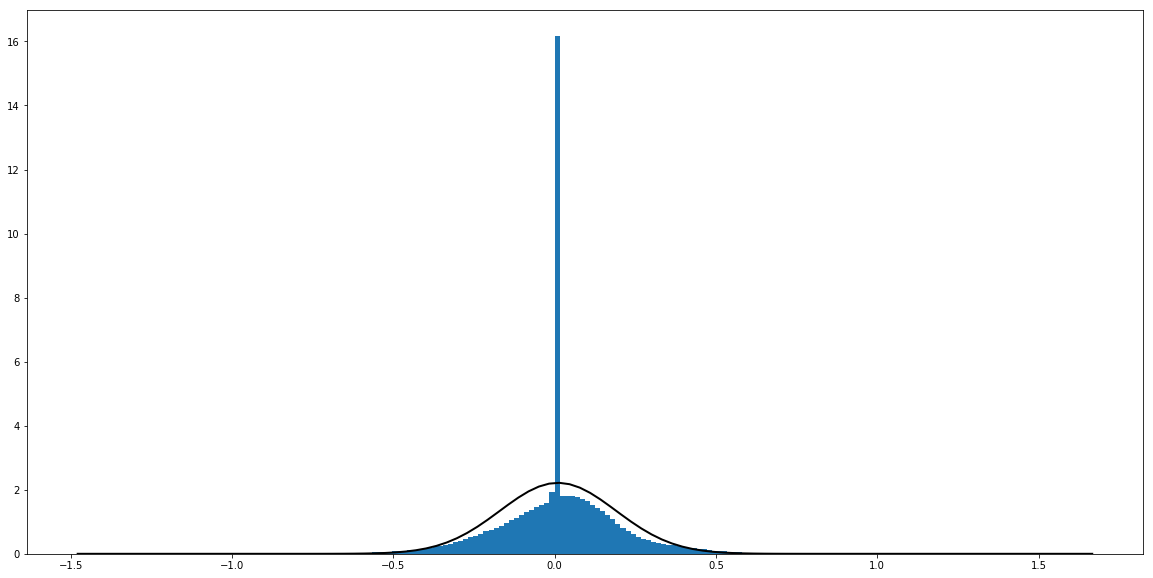

<Figure size 432x288 with 0 Axes>

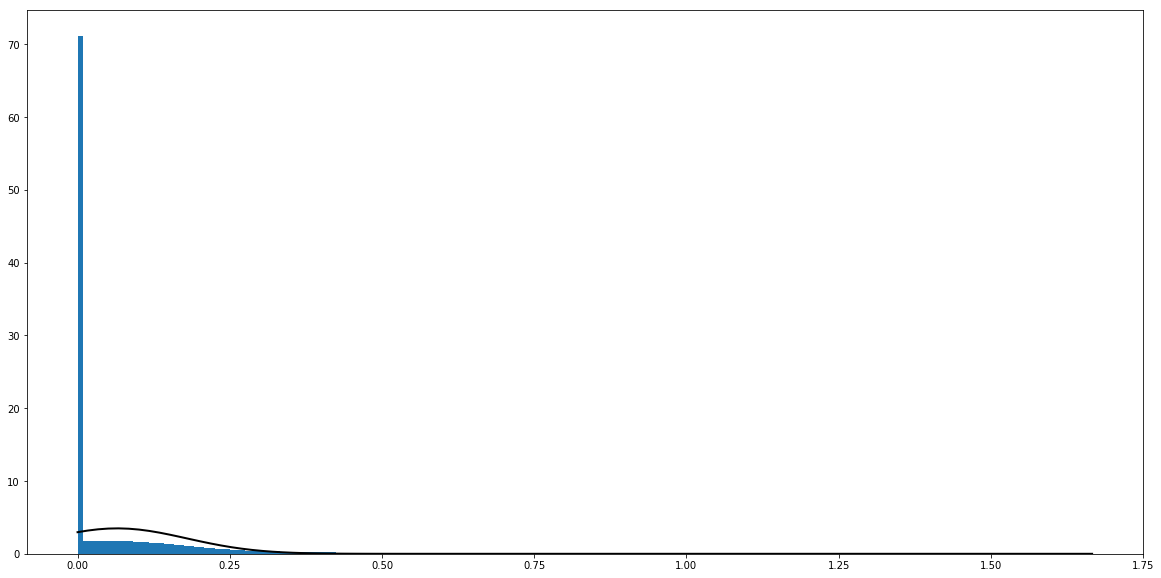

<Figure size 432x288 with 0 Axes>

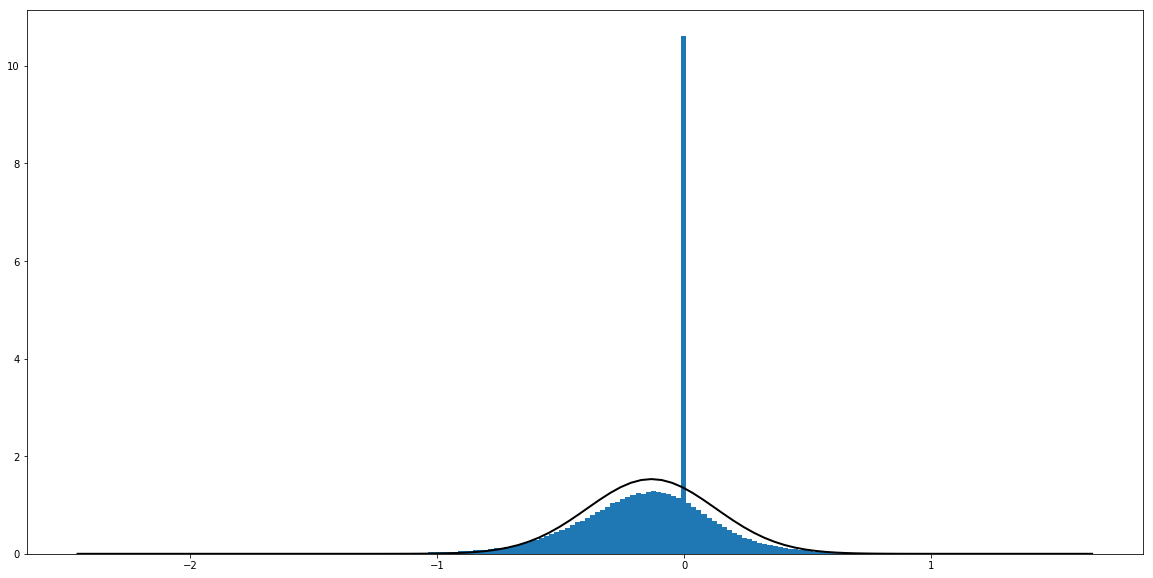

<Figure size 432x288 with 0 Axes>

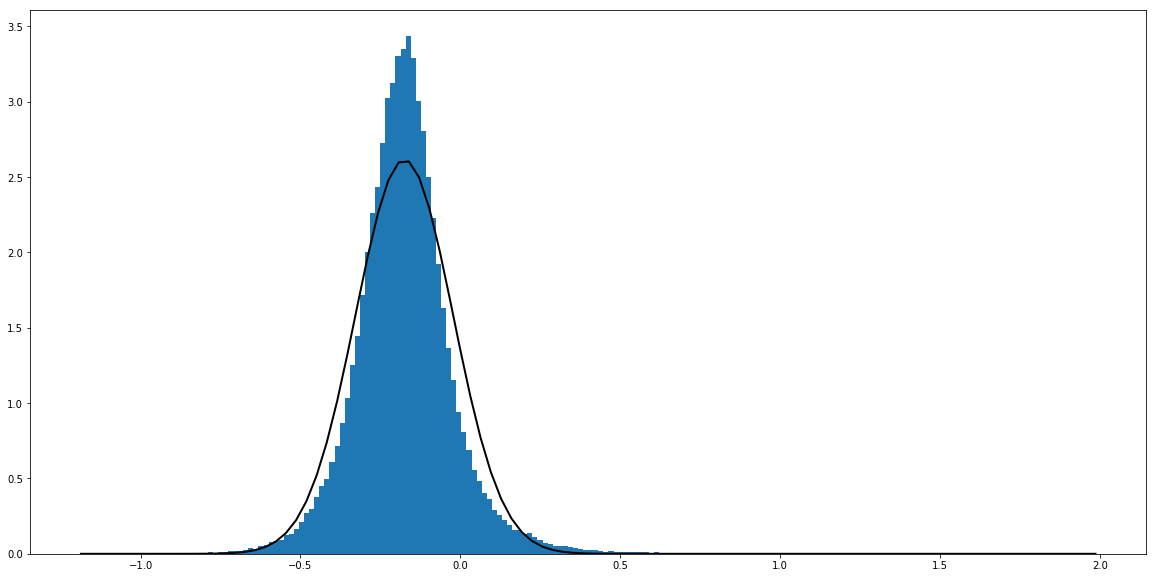

<Figure size 432x288 with 0 Axes>

In [13]:
from collections import OrderedDict
from scipy.stats import norm
import matplotlib.pyplot as plt

def replace_feature(noised, original, idx):
    noised_layer = Noised(original.features[idx])
    noised.features[idx] = noised_layer

class Noised(torch.nn.Module):
    def __init__(self, original):
        super().__init__()
        self.original = original
        print("hooking {}".format(type(original).__name__))
        
    def show_actmap(self, x):
        while len(x.shape) < 4:
            print(x.shape)
            x = x.unsqueeze(0)
        hmap = x.detach().cpu().numpy()
        hmap = hmap.mean(axis=(0, 1))
        print(hmap.shape)
        plt.figure()
        plt.imshow(hmap, cmap="Greys")
    
    def show_hist(self, x):
        acts = x.detach().cpu().numpy()
        acts = acts.flatten()
        print(acts.mean())
        print(acts.std())
        
        f = plt.figure(figsize=(20, 10))
        plt.hist(acts, bins=200, density=True)
        
        mu, std = norm.fit(acts)
        xmin, xmax = min(acts), max(acts)
        plt_x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(plt_x, mu, std)
        plt.plot(plt_x, p, 'k', linewidth=2)
        
        f = plt.figure()
        
    def forward(self, x):
        x = self.original.forward(x)
        self.show_hist(x[0])
        return x
    
replace_feature(noised, original, 14)
replace_feature(noised, original, 15)
replace_feature(noised, original, 16)
replace_feature(noised, original, 17)
replace_feature(noised, original, 49)

img = loader.read(3)
loader.show_img(img)
print(loader.get_result(noised, img))
print(loader.get_result(original, img))